In [1]:
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import SAC
import logging
import gym
import numpy as np
import os

# add reference libraries here. Current structure will use the relative path from this file
libs = ["../../../OpenIPSL-1.5.0/OpenIPSL/package.mo"]

# check that all the paths to library package.mo files exist
# DymolaInterface() also checks this but I've found this warning helpful
for lib in libs:
    if not os.path.isfile(lib):
        print(f"Cannot find the library {lib}")

mo_name = "OpenIPSL.Examples.IEEE9.IEEE_9_Base_Case_OL" # name of Modelica model in the Library.Model format
env_entry_point = 'examples:IEEE9Env' # Python package location of RL environment

time_step = 1.5 # time delta in seconds
positive_reward = 1
negative_reward = -100 # penalize RL agent for is_done
log_level = 0
default_action = [0,0,0]

# these config values are passed to the model specific environment class
# mo_name and libs are passed on to the DymolaBaseEnv class
config = {
    'mo_name': mo_name,
    'libs': libs,
#     'actions': actions,
#     'states': states,
    'time_step': time_step,
    'positive_reward': positive_reward,
    'negative_reward': negative_reward,
    'log_level': log_level,
    'default_action': default_action
}

# enable the model specific class as an OpenAI gym environment
from gym.envs.registration import register
env_name = "MicrogridEnv-v0"

register(
    id=env_name,
    entry_point=env_entry_point,
    kwargs=config
)

In [2]:
# create the environment. this will run an initial step and must return [True, [...]] or something is broken
# TODO: create error handling/warnings if simulations don't work (i.e. returns [False], [...])
env = gym.make(env_name)

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


C:\Users\Aisling\.conda\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
env.reset_dymola()

resetting dymola...
dymola has been reset


In [ ]:
mode = 'learn'

if mode == 'load':
    model = SAC.load("IEEE9_5k_v2", env=env)
else:
    model = SAC(MlpPolicy, env, learning_rate=10**-4, verbose=1)
    

In [ ]:
import time

tic = time.time()

# for i in range(10):
model.env.reset() 
model.learn(5, reset_num_timesteps=False)
model.save("IEEE9_5k_v3")

toc = time.time()
print(toc-tic)

In [8]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
obs = env.reset()
sum_rewards = 0
dn_voltage = []
for i in range(34):
    print(i)
    #action = model.predict(obs) # forces change in p_mech reference for dispatch
    action = [0,0,0] # weird behavior where the model thinks the action output by model.predict has len() = 2
    obs, reward, done, info = env.step(action)
#     print(env.start)
#     if done:
#         env.reset()
    dn_voltage += env.state[:9]
    sum_rewards += reward

the model will be reset
the model has been reset
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [ ]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
obs = env.reset()
# action = model.predict(obs)
rand_sum_rewards = 0
rand_voltage = []
for i in range(50):
#     print(i)
    action = env.action_space.sample() # forces change in p_mech reference for dispatch
    obs, reward, done, info = env.step(action)
    print(env.state)
    rand_voltage += env.state[:9]
    rand_sum_rewards += reward

In [ ]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
obs = env.reset()
# action = model.predict(obs)
rl_sum_rewards = 0
b_voltage = []
for i in range(50):
#     print(i)
    action = model.predict(obs)[0] # forces change in p_mech reference for dispatch
    obs, reward, done, info = env.step(action)
    print(env.state)
    b_voltage += env.state[:9]
    rl_sum_rewards += reward

In [ ]:
for i in range(100):
    obs = env.reset()
    model.learn(100, reset_num_timesteps=False)

In [ ]:
from matplotlib import pyplot as plt 
  
# x-axis values 
x = np.arange(10) 
  
# Y-axis values 
w = np.reshape(dn_voltage, (9,-1))

# Function to plot scatter 
for i in range(9):
    plt.plot(x, w[i,:])
# function to show the plot 
plt.show()

0.034889293384728945
0.04050197954774516
0.025949577780470273
0.012465534304989114
0.008717416657678294
0.011660198717188259
0.022750343353999457
0.037080357730898274
0.05037069531731884


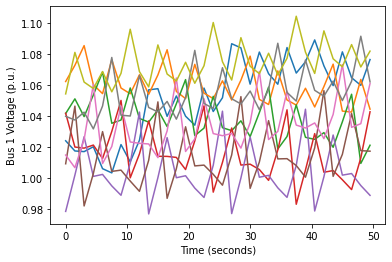

In [9]:
from matplotlib import pyplot as plt 
  
# x-axis values 
x = time_step*np.arange(34) 

for i in range(9):
    # Y-axis values 
    w = np.reshape(dn_voltage, (9,-1))[i,:]
    # y = np.reshape(b_voltage, (9,-1))[0,:]
    # z = np.reshape(dn_voltage, (9,-1))[0,:]

    print(sum(abs(w-1))/50)
    # print(sum(abs(y-1))/50)
    # print(sum(abs(z-1))/50)

    # Function to plot scatter 
    plt.plot(x, w)
    # plt.plot(x, abs(y-1)) 
    # plt.plot(x, abs(z-1))
# plt.legend(['Baseline', 'RL Agent', 'Randomized'])
plt.xlabel('Time (seconds)')
plt.ylabel('Bus 1 Voltage (p.u.)')
# function to show the plot 
plt.show()

In [ ]:
for i in range(9):
    print(np.sum(np.abs(np.reshape(b_voltage, (9,-1))[i,:]-1)) - np.sum(np.abs((np.reshape(dn_voltage, (9,-1))[i,:]-1))), np.sum(np.abs(np.reshape(rand_voltage, (9,-1))[i,:]-1)) - np.sum(np.abs(np.reshape(dn_voltage, (9,-1))[i,:]-1)))

In [ ]:
from matplotlib import pyplot as plt 
  
# x-axis values 
x = np.arange(50) 
  
# Y-axis values 
w = np.reshape(rand_voltage, (9,-1))[6,:]
y = np.reshape(b_voltage, (9,-1))[6,:]
z = np.reshape(dn_voltage, (9,-1))[6,:]
print(sum(abs(w-1))/50)
print(sum(abs(y-1))/50)
print(sum(abs(z-1))/50)
# Function to plot scatter 
plt.plot(x, abs(w-1))
plt.plot(x, abs(y-1)) 
plt.plot(x, abs(z-1))
plt.legend(['Randomized', 'RL Agent', 'Baseline'])
plt.xlabel('Time (seconds)')
plt.ylabel('Bus 7 Voltage (p.u.)')
# function to show the plot 
plt.show()

In [ ]:
10000/60/60

In [ ]:

import os
env.dymola.cd(os.getcwd())

In [ ]:
print(env.dymola.openModel("../../OpenIPSL-1.5.0/OpenIPSL/package.mo"))

In [ ]:
env.dymola.simulateModel('OpenIPSL.Examples.IEEE9.IEEE_9_Base_Case_OL')

In [ ]:
env.dymola.getLastError()

In [ ]:
#env.dymola.close()
from dymola.dymola_interface import DymolaInterface
env.dymola = DymolaInterface()

In [ ]:
from dymola.dymola_interface import DymolaInterface
import os
#dymola = DymolaInterface()
env.dymola.ExecuteCommand("Advanced.Define.DAEsolver = true")

# load libraries
loaded = []
for lib in ["../../OpenIPSL-1.5.0/OpenIPSL/package.mo"]: # all paths relative to the cwd
    loaded += [env.dymola.openModel(lib, changeDirectory=False)]

# if not False in loaded:
#     logger.debug("Successfully loaded all libraries.")
# else:
#     logger.error("Dymola could not find all models.")

if not os.path.isdir('temp_dir'):
    os.mkdir('temp_dir')
    temp_dir = os.path.join(os.getcwd(), "temp_dir")
    env.dymola.cd('temp_dir')

In [ ]:
env.dymola.cd('temp_dir')

In [ ]:
import time
import concurrent.futures as futures


def timeout(timelimit):
    def decorator(func):
        def decorated(*args, **kwargs):
            with futures.ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(func, *args, **kwargs)
                try:
                    result = future.result(timelimit)
                except futures.TimeoutError:
                    print('Time out!')
                    result= None
                else:
                    print(result)
                executor._threads.clear()
                futures.thread._threads_queues.clear()
                return result
        return decorated
    return decorator



class MyClass:
    def __init__(self, x):
        self.x = x
    
    @timeout(2)
    def sleeper(self):
        print(f'Sleeping for {self.x} seconds')
        time.sleep(self.x)
        # Real code here.
        return 'Done', 'yes'